In [73]:
import os
os.chdir('../ssl_neuron/')

In [74]:
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from allensdk.core.cell_types_cache import CellTypesCache

In [75]:
from ssl_neuron.datasets import AllenDataset

In [76]:
config = json.load(open('./ssl_neuron/configs/config.json'))
config['data']['n_nodes'] = 1000

In [77]:
ctc = CellTypesCache(manifest_file='./ssl_neuron/data/cell_types/manifest.json')

In [78]:
cells = ctc.get_cells()

ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)

morphology_features = ctc.get_morphology_features()
morph_df = pd.DataFrame(morphology_features)

In [79]:
dset = AllenDataset(config, mode='all')

430it [00:06, 62.50it/s] 


KeyboardInterrupt: 

In [ ]:
latents = np.load('../analysis/latents.npy')

In [121]:
ef_df = ef_df.set_index('specimen_id').loc[dset.cell_ids]

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [118]:
ef_df

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
0,NaN,134.700000,22.697498,8.335459e-02,1.187680,13.295200,1.025916,-56.375004,-57.385420,-57.431251,...,13.295680,1.134780,-56.593754,-57.739586,-74.143753,3.029695,3.061646,2.969821,-80.468750,-73.553391
1,NaN,NaN,-24.887498,-3.913630e-19,1.099840,20.650105,1.025460,-54.000000,-54.828129,-54.656254,...,20.650735,1.160940,-55.406254,-55.242191,-73.500000,2.441895,2.245653,2.231575,-84.406258,-73.056595
2,0.009770,39.044800,-46.765002,5.267857e-01,1.157840,2.551310,1.025387,-59.500000,-58.234378,-59.940975,...,2.551960,1.089851,-60.062500,-58.570314,-61.371531,2.023762,2.162878,2.006406,-93.375008,-60.277321
3,-0.007898,117.816429,5.996250,1.542553e-01,1.989165,9.572025,1.028733,-47.531250,-50.359375,-65.500000,...,9.576308,1.423229,-49.406254,-52.718752,-75.273443,3.105931,3.491663,1.733896,-87.656250,-75.205559
4,0.022842,68.321429,14.910000,1.714041e-01,1.081980,2.462880,1.025620,-48.437504,-46.520837,-51.406253,...,2.490433,1.479690,-53.000004,-54.645837,-64.250003,3.285760,3.363504,4.234701,-81.625008,-63.474991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0.001963,9.182407,-1.750000,1.013889e+00,1.030300,12.216160,1.024077,-58.781250,-56.218753,-62.375003,...,12.216207,1.255667,-58.937500,-56.322920,-78.666672,1.477299,1.234940,1.447535,-88.937508,-78.321983
2329,0.064670,102.640000,25.802499,1.585265e-01,1.273960,2.804420,1.025750,-49.187504,-49.062500,-50.593752,...,2.847900,1.979330,-61.281254,-59.187500,-74.328125,3.919119,4.053287,4.134621,-96.250008,-74.360977
2330,0.239796,27.853333,-2.267500,7.307692e-02,1.095120,2.426287,1.025020,-51.531250,-50.437501,-52.481252,...,2.426347,1.633196,-51.593750,-50.510418,-70.618750,2.646425,2.688956,2.838209,-95.000008,-70.443848
2331,0.066685,119.322857,-15.087501,1.131737e-01,1.318820,3.928953,1.024840,-52.406250,-54.854169,-52.268752,...,3.929047,1.888704,-52.406250,-54.937503,-75.993753,3.560123,3.500551,3.714190,-98.593758,-79.264778


In [124]:
escore_dict = {}
for col in ef_df.columns:
    if col in ['id']:
        continue
    targets = ef_df[col].to_numpy()
    if targets.dtype == float or targets.dtype == int:
        gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 4)})
        mask = np.isnan(targets)
        if np.sum(~mask) == 0:
            print(f'skipping col {col} because there is no valid data')
            continue
        inputs = latents[~mask]
        targets = targets[~mask]
        targets = StandardScaler().fit_transform(targets[:, None]).flatten()
    elif targets.dtype == bool:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        targets = targets.astype(int)
        gscv = GridSearchCV(LogisticRegression(), {})
    elif targets.dtype == str:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        targets = LabelEncoder().fit_transform(targets)
        gscv = GridSearchCV(LogisticRegression(), {})
    else:
        print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
        continue
    gscv.fit(inputs, targets)
    escore_dict[col] = gscv.best_score_

skipping col has_burst because there is only one value
skipping col has_delay because there is only one value
skipping col has_pause because there is only one value


In [ ]:
max(list(escore_dict.values()))

0.09919290658968702

(-1.0, 1.0)

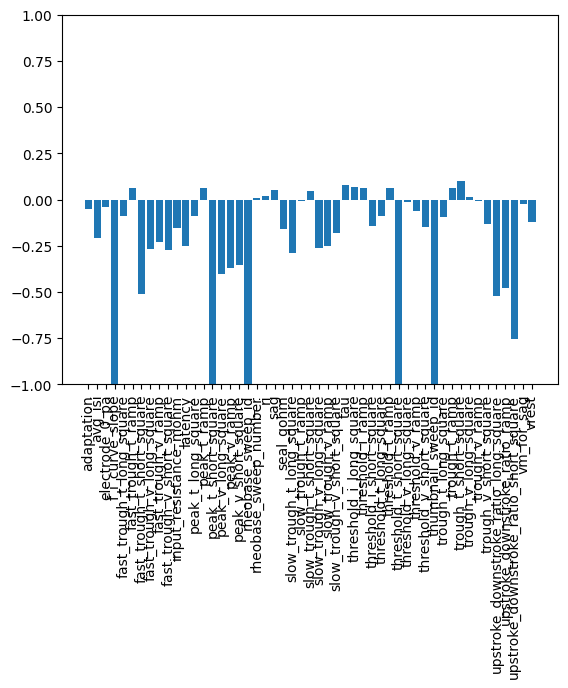

In [140]:
plt.bar(list(escore_dict.keys()), list(escore_dict.values()))
plt.xticks(rotation=90)
plt.ylim(-1, 1)

In [129]:
morph_df = morph_df[~morph_df.superseded].set_index('specimen_id').loc[dset.cell_ids]

In [135]:
mscore_dict = {}
for col in morph_df.columns:
    if col in ['id', 'scale_factor_x', 'scale_factor_y', 'scale_factor_z']:
        continue
    targets = morph_df[col].to_numpy()
    if targets.dtype == float or targets.dtype == int:
        gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 4)})
        mask = np.isnan(targets)
        if np.sum(~mask) == 0:
            print(f'skipping col {col} because there is no valid data')
            continue
        inputs = latents[~mask]
        targets = targets[~mask]
        targets = StandardScaler().fit_transform(targets[:, None]).flatten()
    elif targets.dtype == bool:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        targets = targets.astype(int)
        gscv = GridSearchCV(LogisticRegression(), {})
    elif targets.dtype == str:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        targets = LabelEncoder().fit_transform(targets)
        gscv = GridSearchCV(LogisticRegression(), {})
    else:
        print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
        continue
    gscv.fit(inputs, targets)
    mscore_dict[col] = gscv.best_score_

skipping col average_bifurcation_angle_remote because there is no valid data
skipping col hausdorff_dimension because there is no valid data
skipping col neuron_reconstruction_type due to unsupported dtype object
skipping col superseded because there is only one value
skipping col tags due to unsupported dtype object


(-1.0, 1.0)

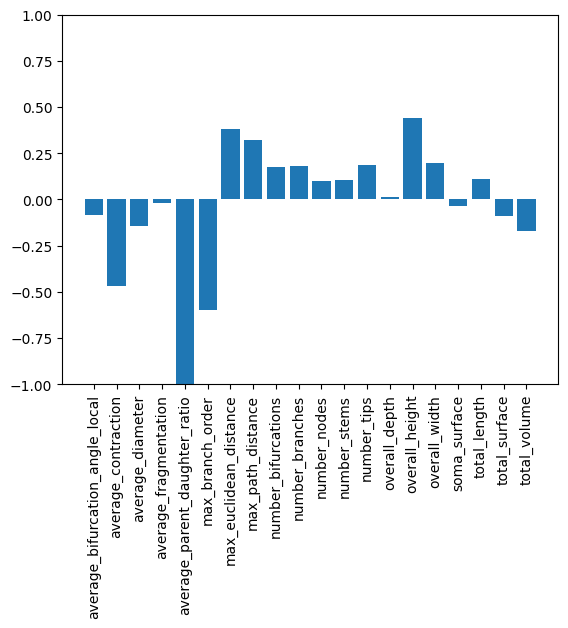

In [139]:
plt.bar(list(mscore_dict.keys()), list(mscore_dict.values()))
plt.xticks(rotation=90)
plt.ylim(-1, 1)

In [69]:
cell_df = pd.DataFrame(cells)
cell_df = cell_df.set_index('id').loc[dset.cell_ids]

In [142]:
cscore_dict = {}
for col in cell_df.columns:
    if col in ['name', 'species', 'donor_id']:
        continue
    elif col in ['structure_area_id']:
        targets = np.array([str(sa_id) for sa_id in cell_df[col]], dtype='object')
    else:
        targets = cell_df[col].to_numpy()
    if targets.dtype == float or targets.dtype == int:
        gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 4)})
        mask = np.isnan(targets)
        if np.sum(~mask) == 0:
            print(f'skipping col {col} because there is no valid data')
            continue
        inputs = latents[~mask]
        targets = targets[~mask]
        targets = StandardScaler().fit_transform(targets[:, None]).flatten()
    elif targets.dtype == bool:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        targets = targets.astype(int)
        gscv = GridSearchCV(LogisticRegression(), {})
    elif type(targets[0]) == str:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        targets = LabelEncoder().fit_transform(targets)
        gscv = GridSearchCV(LogisticRegression(), {})
    else:
        print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
        continue
    gscv.fit(inputs, targets)
    cscore_dict[col] = gscv.best_score_

skipping col cell_soma_location due to unsupported dtype object


/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

skipping col disease_state because there is only one value


(-1.0, 1.0)

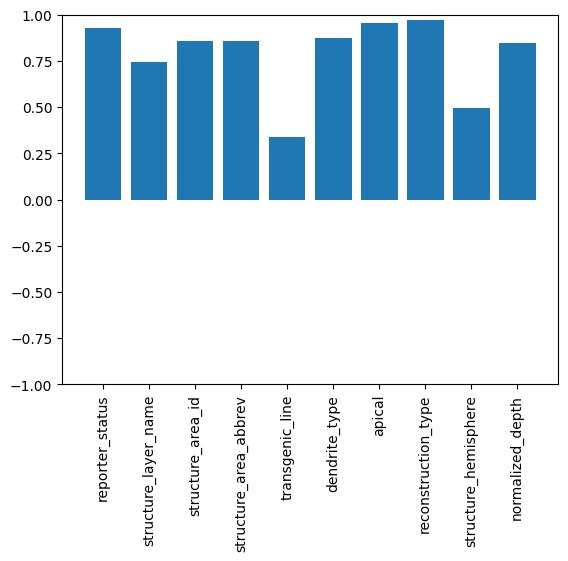

In [143]:
plt.bar(list(cscore_dict.keys()), list(cscore_dict.values()))
plt.xticks(rotation=90)
plt.ylim(-1, 1)